## Imports

In [4]:
import copy
import sys
import uuid
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
submission_path = Path("../XTXStarterKit/").as_posix()
if submission_path not in sys.path:
    sys.path.insert(0, submission_path)

In [3]:
import python.utils
import python.model

In [4]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

In [5]:
%load_ext autoreload
%autoreload 2

## Parameters

In [6]:
NOTEBOOK_PATH = Path("train_convnet").resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_convnet')

In [7]:
device = torch.device("cuda:0")

## Workspace

In [8]:
!ls ../data/

data-training.csv.gz


### Load data

In [9]:
data_training = pd.read_csv("../data/data-training.csv.gz")

In [10]:
rate_cols = [c for c in data_training.columns if "Rate" in c]
size_cols = [c for c in data_training.columns if "Size" in c]
other_cols = [c for c in data_training.columns if c not in rate_cols and c not in size_cols]
data_training = data_training[rate_cols + size_cols + other_cols]

In [11]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0       NaN       NaN       NaN       NaN   
1    1619.5    1620.0    1621.0    1621.5       NaN       NaN       NaN   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0       NaN       NaN       NaN        NaN        NaN        NaN        NaN   
1       NaN       NaN       NaN        NaN        NaN        NaN        NaN   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
0        NaN    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   
1        NaN    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   
1    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
0     1601.0     1600.0       1.0      10.0      24.0       NaN       NaN   
1     1601.0     1600.0       1.0      10.0      24.0       5.0       NaN   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
0       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
1       NaN       NaN       NaN       NaN       NaN        NaN        NaN   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
0        NaN        NaN        NaN       7.0      10.0       1.0      10.0   
1        NaN        NaN        NaN       7.0      10.0       1.0      10.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0       10.0        1.0       10.0       13.0 -0.5  
1       10.0        1.0       10.0       13.0 -0.5

2999999


In [12]:
data_training = python.utils.fix_input_df(data_training)

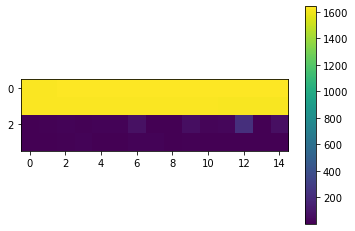

In [13]:
plt.imshow(data_training.drop("y", axis=1).iloc[100200].astype(np.float32).values.reshape(4, 15))
plt.colorbar()

In [14]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0    1621.0    1621.0    1621.0    1621.0   
1    1619.5    1620.0    1621.0    1621.5    1621.5    1621.5    1621.5   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0    1621.0    1621.0    1621.0     1621.0     1621.0     1621.0     1621.0   
1    1621.5    1621.5    1621.5     1621.5     1621.5     1621.5     1621.5   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
0     1621.0    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   
1     1621.5    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   
1    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
0     1601.0     1600.0       1.0      10.0      24.0       0.0       0.0   
1     1601.0     1600.0       1.0      10.0      24.0       5.0       0.0   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
0       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
1       0.0       0.0       0.0       0.0       0.0        0.0        0.0   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
0        0.0        0.0        0.0       7.0      10.0       1.0      10.0   
1        0.0        0.0        0.0       7.0      10.0       1.0      10.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0       10.0        1.0       10.0       13.0 -0.5  
1       10.0        1.0       10.0       13.0 -0.5

2999999


In [15]:
def normalize_df(df, rate_mean, rate_std, size_mean, size_std):
    for col in df:
        if "Rate" in col:
            df[col] = (df[col] - rate_mean) / rate_std
        elif "Size" in col:
            df[col] = (df[col] - size_mean) / size_std
        else:
            print(col)

In [16]:
TRAIN_TEST_SPLITS = []
for i in range(5):
    start = int(len(data_training) * 0.2 * i)
    stop = int(len(data_training) * 0.2 * (i + 1))
    
    train_df = pd.concat([data_training.iloc[:start], data_training.iloc[stop:]]).copy()
    valid_df = data_training.iloc[start:stop].copy()
    assert len(train_df) + len(valid_df) == len(data_training)
    assert not set(train_df.index) & set(valid_df.index)
    
    rate_mean = train_df[[c for c in train_df.columns if "Rate" in c]].values.mean()
    rate_std = train_df[[c for c in train_df.columns if "Rate" in c]].values.std()
    size_mean = train_df[[c for c in train_df.columns if "Size" in c]].values.mean()
    size_std = train_df[[c for c in train_df.columns if "Size" in c]].values.std()
    normalize_df(train_df, rate_mean, rate_std, size_mean, size_std)
    normalize_df(valid_df, rate_mean, rate_std, size_mean, size_std)
    print(i, rate_mean, rate_std, size_mean, size_std)

    TRAIN_TEST_SPLITS.append((train_df, valid_df))

y
y
0 1644.612596201389 28.54522304768283 17.23235076388889 31.378056039704777
y
y
1 1637.7148071172808 27.528697193345476 17.976835573681488 33.539837002914624
y
y
2 1647.1994378539325 26.69847660857911 17.870208626475815 33.81782406661056
y
y
3 1635.8714673283891 25.095456936983673 16.48420107675045 29.002142948267682
y
y
4 1644.7164182082297 26.44444556804018 16.40631648874298 30.892679956916375


In [17]:
train_df, valid_df = TRAIN_TEST_SPLITS[0]

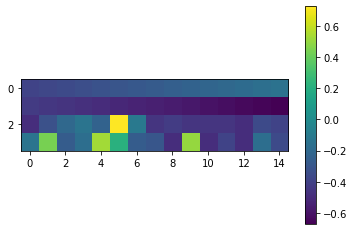

In [18]:
plt.imshow(train_df.drop("y", axis=1).iloc[0].astype(np.float32).values.reshape(4, 15))
plt.colorbar()

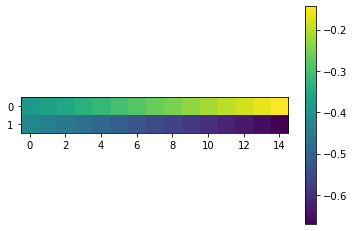

In [19]:
plt.imshow(train_df.drop("y", axis=1).iloc[0].astype(np.float32).values.reshape(4, 15)[:2, :])
plt.colorbar()

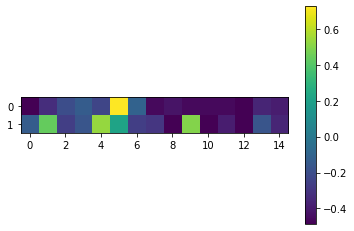

In [20]:
plt.imshow(train_df.drop("y", axis=1).iloc[0].astype(np.float32).values.reshape(4, 15)[2:, :])
plt.colorbar()

### Define model

In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset


class XTXDataset(Dataset):
    max_values = None

    def __init__(self, data, num_previous=1) -> None:
        super().__init__()
        assert num_previous > 0
        values = data[:, :-1]
        targets = data[:, -1:]

        values = np.flip(values, 0)
        targets = np.flip(targets, 0)

        #         self.values = values.reshape(values.shape[0], 4, 15).transpose([1, 2, 0]).copy()
        self.values = values.copy()
        self.targets = targets.copy()

        self.num_previous = num_previous

    def __len__(self):
        return self.targets.shape[0] - self.num_previous + 1

    def __getitem__(self, index):
        values = self.values[:, :, index : index + self.num_previous]
        targets = self.targets[index : index + self.num_previous, :]

        #         perm = np.arange(15)
        #         np.random.shuffle(perm)
        #         values = values[:, perm, :]

        return values, targets


class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_previous):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_previous, d_model)
        position = torch.arange(0, max_previous).unsqueeze(1).to(torch.float32)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).to(torch.float32)
            * -(np.log(max_previous * 10) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


class XTXModel(nn.Module):
    def __init__(self, dropout=0.5, num_previous=1):
        super().__init__()
        self.num_previous = num_previous

        self.layer1 = nn.Sequential(
            #
            nn.Conv2d(4, 128, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv2d(128, 12, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
        )
        self.norm1 = nn.LayerNorm((12, 15, num_previous))
        self.dropout1 = nn.Dropout(dropout)

        self.layer2 = nn.Sequential(
            #
            nn.Conv2d(15, 128, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv2d(128, 12, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
        )
        self.norm2 = nn.LayerNorm((12 + 12, num_previous))
        self.dropout2 = nn.Dropout(dropout)

        if num_previous:
            self.layer3 = nn.Sequential(
                nn.Linear(num_previous, 128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, 4),
                nn.ReLU(),
            )
            self.norm3 = nn.LayerNorm((12 + 12 + 4))
            self.dropout3 = nn.Dropout(dropout)

        self.linear_out = nn.Sequential(
            #
            nn.Linear(12 + 12 + (4 if num_previous else 0), 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.norm1(x)

        x = x.transpose(1, 2)
        x_out = self.layer2(x)
        x = torch.cat([x[:, 0, :, :], x_out.max(2)[0]], 1)
        x = self.norm2(x)

        if self.num_previous:
            x_out = self.layer3(x)
            x = torch.cat([x[:, :, 0], x_out.max(-2)[0]], 1)
        else:
            x = x[:, :, 0]

        x = self.linear_out(x)
        return x


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [6]:
pe = PositionalEncoding(128, 0.1, 1000)

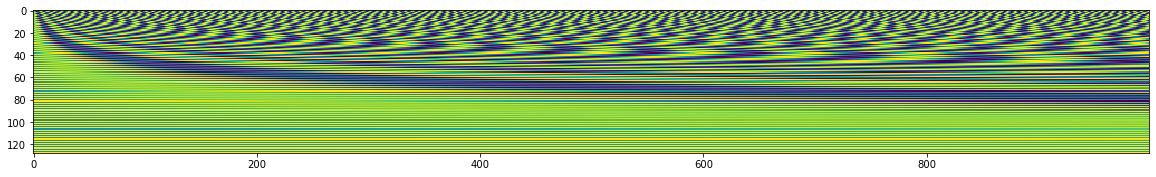

In [7]:
fg, ax = plt.subplots(figsize=(20, 10))
plt.imshow(pe.pe.squeeze().data.numpy().T)

### Train model

In [24]:
batch_size = 1028
num_previous = 1
dropout = 0.5

while True:
    unique_id = str(uuid.uuid4())
    unique_path = NOTEBOOK_PATH.joinpath(unique_id)
    try:
        unique_path.mkdir()
        break
    except FileExistsError:
        continue
print(f"Unique id: '{unique_id}'\n")

max_weighted_scores = []
for split_index, (train_df, valid_df) in enumerate(TRAIN_TEST_SPLITS):
    print(f"Split: {split_index}")

    train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    max_weighted_score = 0
    for repeat_index in range(3):
        print(f"Repeat: {repeat_index}")
        net = XTXModel(dropout=dropout, num_previous=num_previous).to(device)
        criterion = nn.MSELoss(reduction="sum")
        optimizer = optim.AdamW(net.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6], gamma=0.1)

        noise_x = torch.zeros(batch_size, 4, 15, num_previous).to(device)
        noise_y = torch.zeros(batch_size, 1).to(device)
        for epoch in range(10):
            print(f"Epoch: {epoch}")
            train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

            net.train()

            scores = []
            for i, batch in enumerate(train_loader):
                x, y = batch
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad()
        #         noise_x.normal_(0, 0.1)
                out = net(x + noise_x[:x.size(0), :, :, :])
        #         noise_y.normal_(0, 0.1)
                loss = criterion(out, y[:, 0] + noise_y[:y.size(0), :])
                loss.backward()
                optimizer.step()

                if i % 500 == 0:
                    last_ys = y[:, 0].squeeze()
                    last_outs = out.squeeze()
                    score = (
                        1 - ((last_ys - last_outs) ** 2).sum() / (last_ys ** 2).sum()
                    ).item()
                    print(f"{score:.6f}", end=" ")
                    scores.append((i, score))
            scheduler.step()

            net.eval()
            y_list = []
            out_list = []
            for i, batch in enumerate(valid_loader):
                x, y = batch
                x = x.to(device)
                y = y.to(device)

                with torch.no_grad():
                    out = net(x)

                last_ys = y[:, 0].squeeze().to(torch.device("cpu")).data.numpy()
                last_outs = out.squeeze().to(torch.device("cpu")).data.numpy()
                y_list.append(last_ys)
                out_list.append(last_outs)

            last_ys = np.hstack(y_list)
            last_outs = np.hstack(out_list)
            score = (
                1 - ((last_outs - last_ys) ** 2).sum() / (last_ys ** 2).sum()
            ).item()
            print(f"Validation: {score:.6f}")
            
            weighted_score = (score + max(sum([s[1] for s in scores]) / len(scores), 0.04) / 4) / 2  # Need average increase of 0.02 to justify decrease of 0.005
            if weighted_score > max_weighted_score:
                max_weighted_score = weighted_score
                torch.save(net.state_dict(), unique_path.joinpath(f"model_{split_index}.pt"))

    print(f"Best weighted score for split {split_index}: {max_weighted_score:.6f}\n")
    max_weighted_scores.append(max_weighted_score)
    
print(f"Average best validation score: {sum(max_weighted_scores) / len(max_weighted_scores):.6f}")

Unique id: 'e4274a75-a3c6-41c8-8eb0-c10aae2e8c03'

Split: 0
Repeat: 0
Epoch: 0
-0.615059 -0.000023 0.007901 0.013087 0.010576 Validation: 0.009642
Epoch: 1
0.011641 0.019732 0.014853 0.028916 0.016411 Validation: 0.011236
Epoch: 2
0.018180 0.020742 0.021445 0.037005 0.007466 Validation: 0.009946
Epoch: 3
0.004888 0.018410 0.022447 0.022064 0.025780 Validation: 0.009226
Epoch: 4
0.028445 0.006559 0.031890 0.028456 0.019281 Validation: 0.008743
Epoch: 5
0.028513 0.023056 0.018366 0.040888 0.018788 Validation: 0.008241
Epoch: 6
0.023761 0.035756 0.036670 0.010096 0.024412 Validation: 0.008454
Epoch: 7
0.021832 0.011347 0.014947 0.025206 0.032528 Validation: 0.008359
Epoch: 8
0.001344 0.043676 0.013293 0.016686 0.035098 Validation: 0.008406
Epoch: 9
0.018520 0.013999 0.023621 0.013547 0.031887 Validation: 0.008352
Repeat: 1
Epoch: 0
-0.249595 0.003340 0.006846 0.015660 0.012328 Validation: 0.010533
Epoch: 1
0.006897 0.020601 0.011045 0.022264 0.027375 Validation: 0.008136
Epoch: 2
0.016032

In [26]:
unique_id

'e4274a75-a3c6-41c8-8eb0-c10aae2e8c03'